## Insurance cost prediction using linear regression

Using information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person.

In [1]:
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.16                  |              mkl          11 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    cpuonly-1.0                |                0           2 KB  pytorch
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    intel-openmp-2020.1        |              217         780 KB  defaults
    jpeg-9d                    |       h5169

In [2]:
!pip install pandas

     |████████████████████████████████| 10.1 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 38.3 MB/s eta 0:00:01


In [3]:
!pip install seaborn

     |████████████████████████████████| 215 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 10.3 MB/s eta 0:00:01


In [4]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [5]:
project_name = 'insurance-edit-linear-regression'

### 1. Download Dataset

In [6]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

103.1%

In [7]:
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2. Exploring Dataset

In [8]:
num_rows = len(dataframe)
print(num_rows)

1338


In [9]:
num_cols = len(dataframe.columns)
print(num_cols)

7


In [10]:
input_cols = ["age", "sex", "bmi", "children", "smoker", "region"]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

In [11]:
categorical_cols = ["sex", "smoker", "region"]

In [12]:
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [13]:
output_cols = ["charges"]

min:  1121.8739
max:  63770.42801
avg:  13270.422265141257


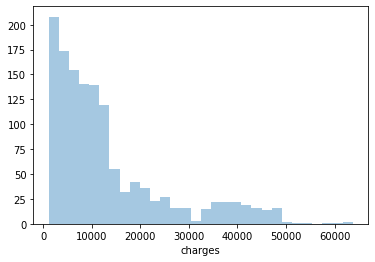

In [14]:
import numpy as np
charges_min=min(dataframe["charges"])
charges_max=max(dataframe["charges"])
charges_avg=np.mean(dataframe["charges"])
print("min: ", charges_min)
print("max: ", charges_max)
print("avg: ", charges_avg)

import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.distplot(dataframe.charges, kde=False)

### 3. Preparing dataset for training

Data must be converted into PyTorch tensors from Pandas dataframe. To do this, it should first be converted to numpy arrays.

In [17]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [18]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
        [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
        [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ],
        ...,
        [18.  ,  0.  , 36.85,  0.  ,  0.  ,  2.  ],
        [21.  ,  0.  , 25.8 ,  0.  ,  0.  ,  3.  ],
        [61.  ,  0.  , 29.07,  0.  ,  1.  ,  1.  ]]),
 array([[16884.924 ],
        [ 1725.5523],
        [ 4449.462 ],
        ...,
        [ 1629.8335],
        [ 2007.945 ],
        [29141.3603]]))

Converting numpy arrays into PyTorch tensors.

In [19]:
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)
inputs, targets

(tensor([[19.0000,  0.0000, 27.9000,  0.0000,  1.0000,  3.0000],
         [18.0000,  1.0000, 33.7700,  1.0000,  0.0000,  2.0000],
         [28.0000,  1.0000, 33.0000,  3.0000,  0.0000,  2.0000],
         ...,
         [18.0000,  0.0000, 36.8500,  0.0000,  0.0000,  2.0000],
         [21.0000,  0.0000, 25.8000,  0.0000,  0.0000,  3.0000],
         [61.0000,  0.0000, 29.0700,  0.0000,  1.0000,  1.0000]],
        dtype=torch.float64),
 tensor([[16884.9240],
         [ 1725.5523],
         [ 4449.4620],
         ...,
         [ 1629.8335],
         [ 2007.9450],
         [29141.3603]], dtype=torch.float64))

In [20]:
dataset = TensorDataset(inputs, targets)

### 4. Creating validation set and Data loader. 

We use 17% of training set for validation. Splitting is done using random_split().

In [22]:
val_percent = 0.17
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds =  random_split(dataset, [train_size, val_size])

Batch size for Data Loader.

In [23]:
batch_size = 32

In [24]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

A Batch of data.

In [25]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[54.0000,  1.0000, 30.8000,  1.0000,  1.0000,  2.0000],
        [41.0000,  1.0000, 34.2000,  2.0000,  0.0000,  1.0000],
        [30.0000,  1.0000, 24.1300,  1.0000,  0.0000,  1.0000],
        [34.0000,  0.0000, 31.9200,  1.0000,  1.0000,  0.0000],
        [33.0000,  0.0000, 33.5000,  0.0000,  1.0000,  3.0000],
        [18.0000,  1.0000, 33.7700,  1.0000,  0.0000,  2.0000],
        [46.0000,  0.0000, 48.0700,  2.0000,  0.0000,  0.0000],
        [51.0000,  0.0000, 18.0500,  0.0000,  0.0000,  1.0000],
        [29.0000,  0.0000, 26.0300,  0.0000,  0.0000,  1.0000],
        [54.0000,  0.0000, 47.4100,  0.0000,  1.0000,  2.0000],
        [31.0000,  0.0000, 32.6800,  1.0000,  0.0000,  1.0000],
        [21.0000,  0.0000, 22.1350,  0.0000,  0.0000,  0.0000],
        [42.0000,  0.0000, 32.8700,  0.0000,  0.0000,  0.0000],
        [19.0000,  0.0000, 27.9300,  3.0000,  0.0000,  1.0000],
        [38.0000,  1.0000, 21.1200,  3.0000,  0.0000,  2.0000],
        [36.0000,  1.0000, 31.50

### 5. Create a Linear Regression Model

In [27]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(6, 1)

In [28]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                      
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                             
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Creating a Model using InsuranceModel class.

In [29]:
model = InsuranceModel()

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0564,  0.1823, -0.3857,  0.3398,  0.1819, -0.3552]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1505], requires_grad=True)]

### 6. Train the model to fit the data

In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

Using the evaluate function to calculate the loss on validation set before training.

In [34]:
result = evaluate(model, val_loader)
result

{'val_loss': 12753.233328132992}

In [35]:
epochs = 120
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7597.5426
Epoch [40], val_loss: 7456.9025
Epoch [60], val_loss: 7325.0546
Epoch [80], val_loss: 7201.1744
Epoch [100], val_loss: 7084.8170
Epoch [120], val_loss: 6980.8791


In [36]:
epochs = 120
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6971.8001
Epoch [40], val_loss: 6963.0156
Epoch [60], val_loss: 6954.4290
Epoch [80], val_loss: 6945.9786
Epoch [100], val_loss: 6937.6840
Epoch [120], val_loss: 6929.4224


In [37]:
epochs = 200
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6928.5985
Epoch [40], val_loss: 6927.7750
Epoch [60], val_loss: 6926.9518
Epoch [80], val_loss: 6926.1269
Epoch [100], val_loss: 6925.3017
Epoch [120], val_loss: 6924.4768
Epoch [140], val_loss: 6923.6551
Epoch [160], val_loss: 6922.8390
Epoch [180], val_loss: 6922.0225
Epoch [200], val_loss: 6921.2059


In [38]:
epochs = 200
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6921.1242
Epoch [40], val_loss: 6921.0426
Epoch [60], val_loss: 6920.9608
Epoch [80], val_loss: 6920.8792
Epoch [100], val_loss: 6920.7976
Epoch [120], val_loss: 6920.7159
Epoch [140], val_loss: 6920.6343
Epoch [160], val_loss: 6920.5525
Epoch [180], val_loss: 6920.4709
Epoch [200], val_loss: 6920.3892


Final validation loss.

In [40]:
val_loss = history4[-1]
val_loss

{'val_loss': 6920.389249954304}

### 7. Make Predictions using the trained model

In [41]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [42]:
input, target = val_ds[53]
predict_single(input, target, model)

Input: tensor([50.0000,  1.0000, 25.3000,  0.0000,  0.0000,  2.0000],
       dtype=torch.float64)
Target: tensor([8442.6670], dtype=torch.float64)
Prediction: tensor([10145.8756], dtype=torch.float64)


In [43]:
input, target = val_ds[19]
predict_single(input, target, model)

Input: tensor([48.0000,  0.0000, 31.1300,  0.0000,  0.0000,  2.0000],
       dtype=torch.float64)
Target: tensor([8280.6227], dtype=torch.float64)
Prediction: tensor([9580.9378], dtype=torch.float64)


In [44]:
input, target = val_ds[76]
predict_single(input, target, model)

Input: tensor([27.0000,  0.0000, 25.1750,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64)
Target: tensor([3558.6202], dtype=torch.float64)
Prediction: tensor([5216.5789], dtype=torch.float64)


In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
